In [1]:
import os
import datetime
import sqlite3
import warnings
import locale

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)
locale.setlocale(
    category=locale.LC_ALL,
    locale="Russian" 
)

'Russian_Russia.1251'

In [3]:
def read_coef(excpt):
    coeff = {datetime.datetime.strptime(filename[-15:-5], '%Y-%m-%d').date(): pd.read_excel(f'used/coeff/{filename}', decimal=',') for filename in os.listdir('used/coeff')}
    for date in coeff:
        coeff[date] = coeff[date][coeff[date]['Склад'] != 'Маркетплейс']
        coeff[date] = coeff[date].astype({'Хранение за 3л': float, 'доп. л.1':float})

        cities = change_names(coeff[date], excpt)
        coeff[date] = coeff[date].T
        coeff[date].columns = cities

    return coeff

In [4]:
def change_names(coeff, excpt):
    names = list(coeff['Склад'])
    for i in range(len(names)):
        if names[i] in excpt:
            continue
        names[i] = names[i].split()[0]
    return names

In [5]:
def read_remains():
    return {datetime.datetime.strptime('_'.join(filename.split('_')[1:])[:-5]+f'_{datetime.datetime.now().year}', '%B_%d_%Y').date(): pd.read_excel(f'used/remains/{filename}') for filename in os.listdir('used/remains')}

In [6]:
def update_remains(remains):
    
    remains.fillna(0, inplace=True)
    remains['Итого в рублях'] = 0
    
    return remains

In [7]:
def calculate_expenses(remains, coeff):
    for city in list(remains.columns[10:-1]):
        remains[city] *= coeff[city]['Хранение за 3л']
        remains.loc[(remains['Объем, л'] > 3) & (remains[city] > 0), city] += (coeff[city]['доп. л.1'] * (remains['Объем, л'] - 3))
        
        remains['Итого в рублях'] += remains[city]
    return remains

In [8]:
def download_result(main_table, date):
    main_table.to_excel(f'created\\{date.strftime("%d_%m_%Y")}.xlsx')

In [9]:
def load_to_db(table, tablename):
    conn = sqlite3.connect('storage.db')
    cursor = conn.cursor()
    table.to_sql(tablename, conn, if_exists='replace', index=False)

In [10]:
def create_sum_table(remains):
    dfs = []
    for date in remains:
        res_df = remains[date].iloc[-1, 10:].to_frame().T
        res_df.index = [date]
        dfs.append(res_df)
    return pd.concat(dfs).dropna(axis=1)

In [11]:
def create_curr_barplot(sum_table, city):
    fig, ax = plt.subplots()

    norm = plt.Normalize(sum_table[city].min(), sum_table[city].max())
    colors_mapped = sns.color_palette("rocket_r", n_colors=len(sum_table)).as_hex()
    colors_mapped = [colors_mapped[int(norm(value) * (len(colors_mapped) - 1))] for value in sum_table[city]]

    sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)

    ax.set_xlabel("Дата")
    ax.set_ylabel("Сумма в рублях")
    ax.set_title(f"Сумма за хранение {city}")

    ax.tick_params(axis='x', labelsize=8)

    plt.savefig(f'graphics/cities/{city}.png')
    plt.show()

In [12]:
def graph_showing_reation(weekly_sum, param):
    weekly_sum = weekly_sum.iloc[:-1, :]    #Удаление суммированных значений
    
    weekly_sum = weekly_sum[weekly_sum[param] > 5]
    mean_value = weekly_sum[param].mean()
    std_dev = weekly_sum[param].std()
    filtered_data = weekly_sum[abs(weekly_sum[param] - mean_value) < 2 * std_dev]
    
    sns.set_style("whitegrid") 
    sns.set_palette("mako")
    plt.figure(figsize=(10, 6))
    sns.regplot(y=filtered_data[param], x=filtered_data['Итого в рублях'], scatter_kws={'alpha':0.5})

    plt.savefig(f'graphics/relation/{param}.png')
    plt.show()

In [13]:
def create_graphs(remains, weekly_sum):
    params_relation = ['В пути до клиента', 'В пути от клиента', 'Объем, л', 'Итого по складам'] 
    for param in params_relation:
        graph_showing_reation(weekly_sum, param)

    sum_table = create_sum_table(remains)
    for city in list(sum_table.columns):
        create_curr_barplot(sum_table, city)


In [14]:
def create_weekly_sum(remains):
    df_week = list(remains.values())
    gr_b = list(df_week[0].iloc[:, :7].columns)
    weekly_sum = pd.concat(df_week).groupby(gr_b).sum(numeric_only=True).reset_index()
    
    weekly_sum.loc['Итого'] = weekly_sum.sum(axis=0, numeric_only=True)
    
    filename = f'weekly_sum_{min(remains.keys()).strftime("%d_%m_%Y")}-{max(remains.keys()).strftime("%d_%m_%Y")}'
    weekly_sum.to_excel(f'summary_reports\\filename.xlsx')

    load_to_db(weekly_sum, filename)
    return weekly_sum

In [15]:
def create_remains_on_tariff(excpt_city_names=[]):
    remains, coeff = read_remains(), read_coef(excpt_city_names)
    for date in coeff:
        if date not in remains:
            warnings.warn("Закройте используемые файлы", DeprecationWarning)
            continue
        
        remains[date], coeff[date] = update_remains(remains[date]), coeff[date].to_dict()

        remains[date] = calculate_expenses(remains[date], coeff[date])
        remains[date].loc['Итого'] = remains[date].sum(axis=0, numeric_only=True)
        remains[date].sort_values(by=['Бренд', 'Предмет', 'Артикул продавца'], inplace=True)

        try:
            download_result(remains[date], date)
        except PermissionError:
            warnings.warn("Закройте используемые файлы", DeprecationWarning)

    weekly_sum = create_weekly_sum(remains)
    create_graphs(remains, weekly_sum)

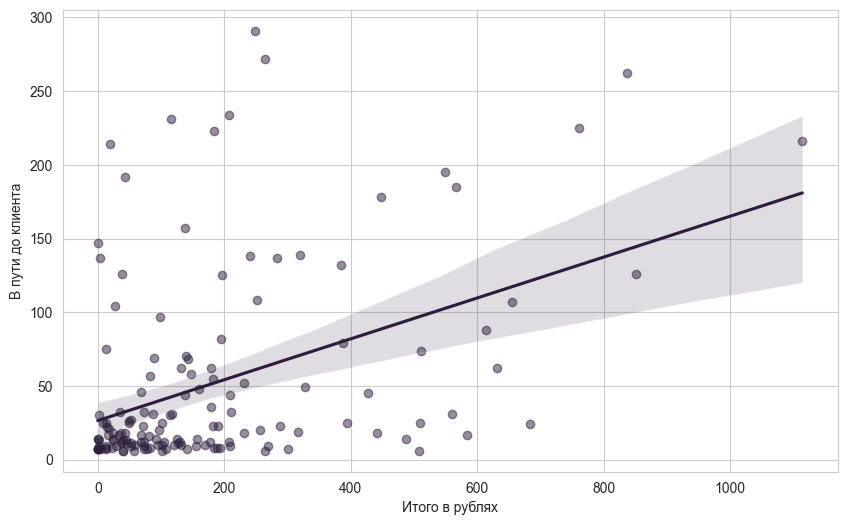

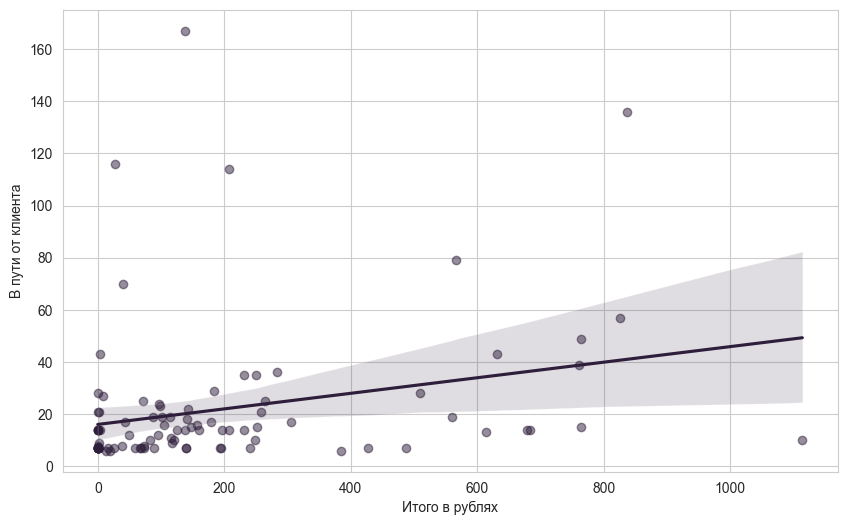

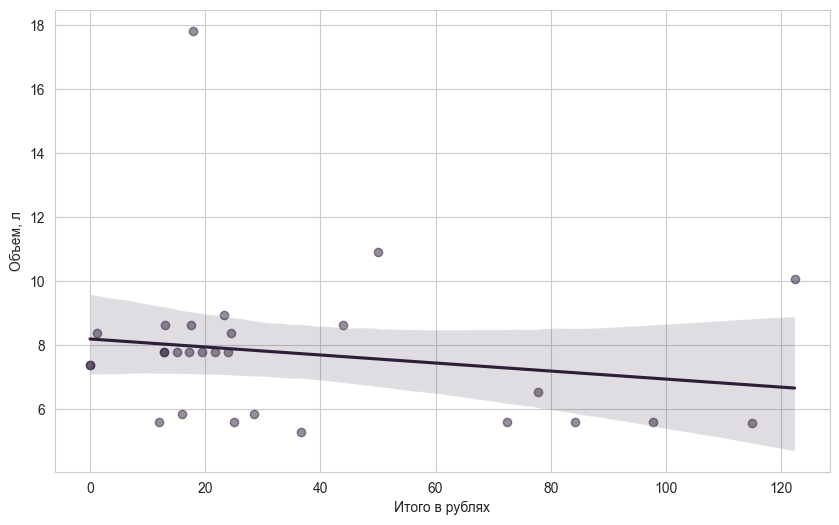

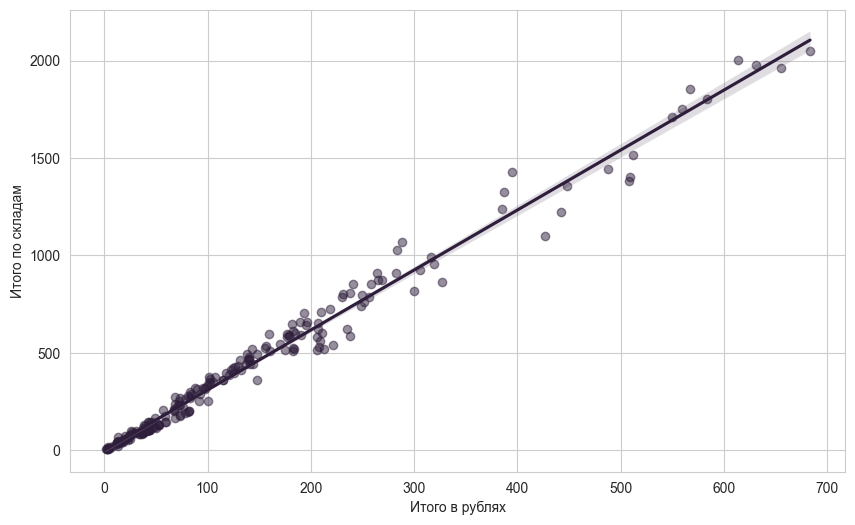

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2728\3077699709.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


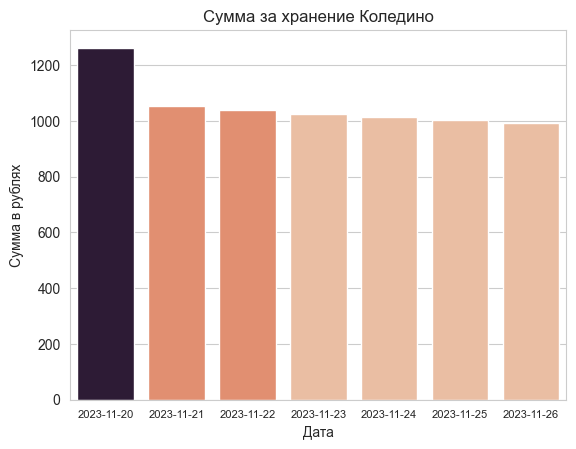

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2728\3077699709.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


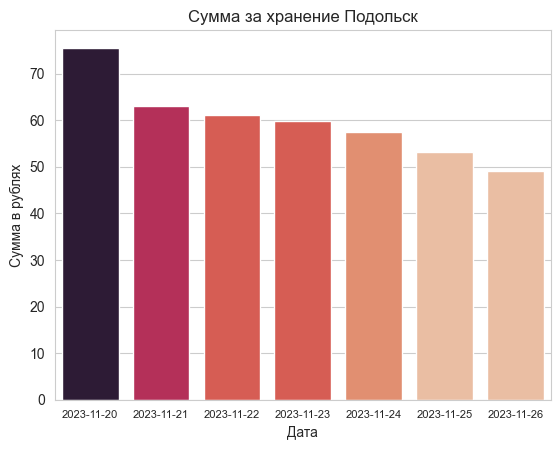

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2728\3077699709.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


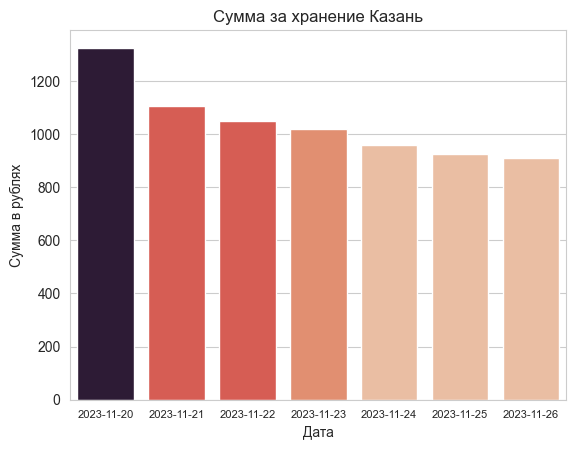

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2728\3077699709.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


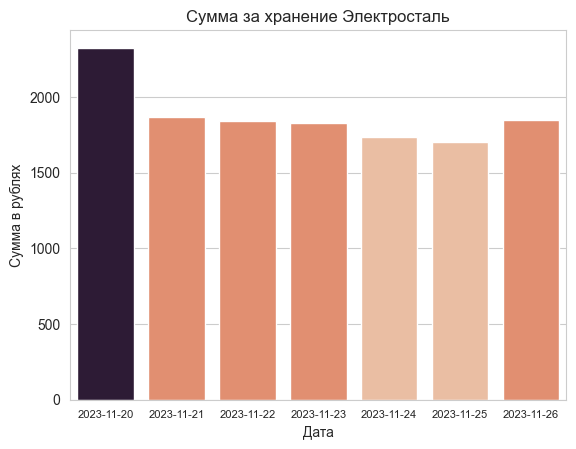

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2728\3077699709.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


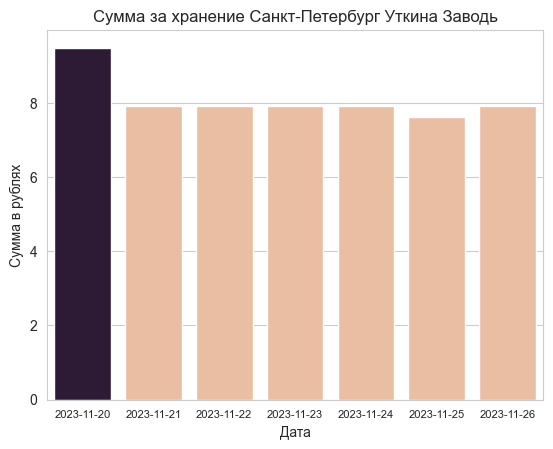

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2728\3077699709.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


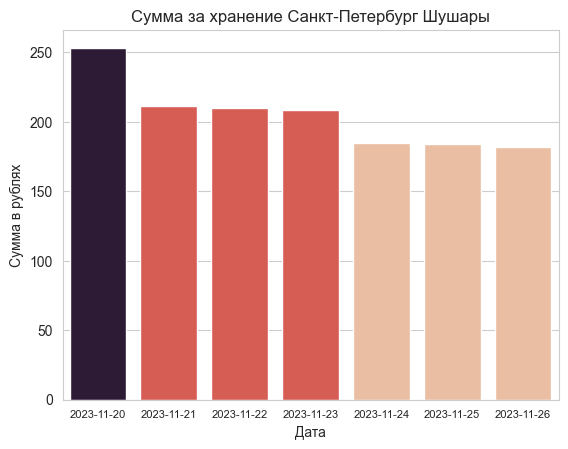

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2728\3077699709.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


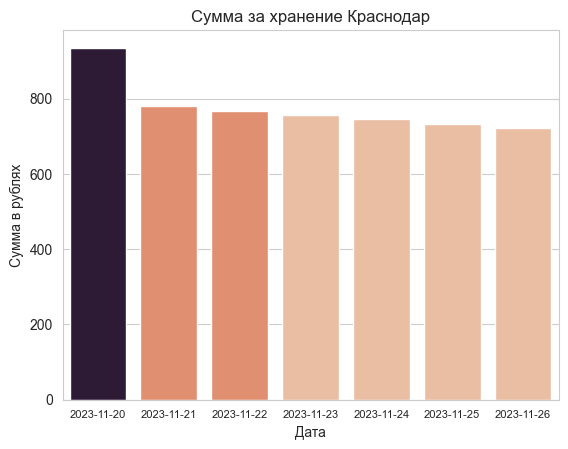

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2728\3077699709.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


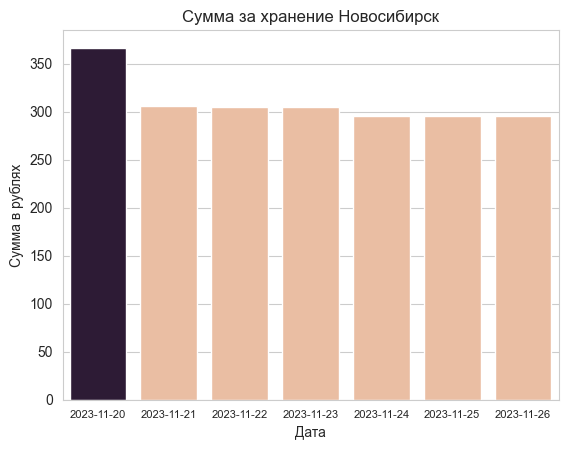

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2728\3077699709.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


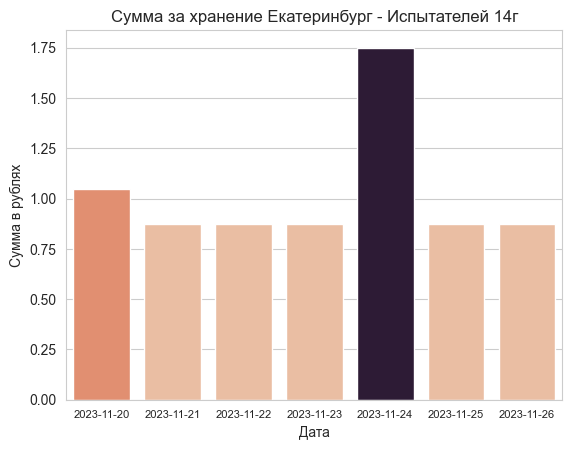

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2728\3077699709.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


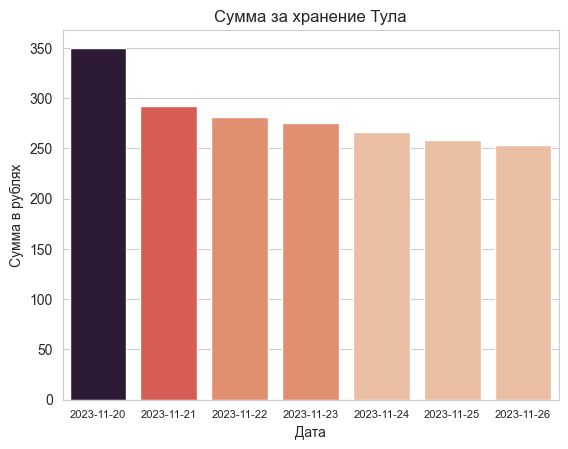

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2728\3077699709.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


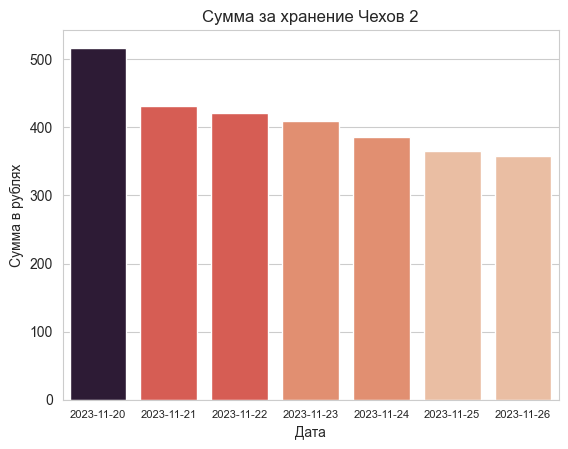

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2728\3077699709.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


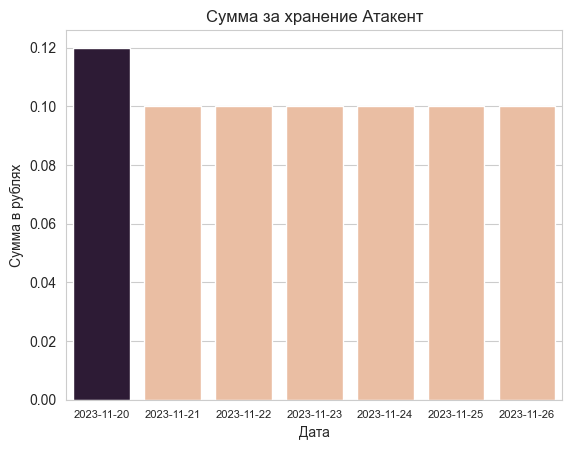

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2728\3077699709.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


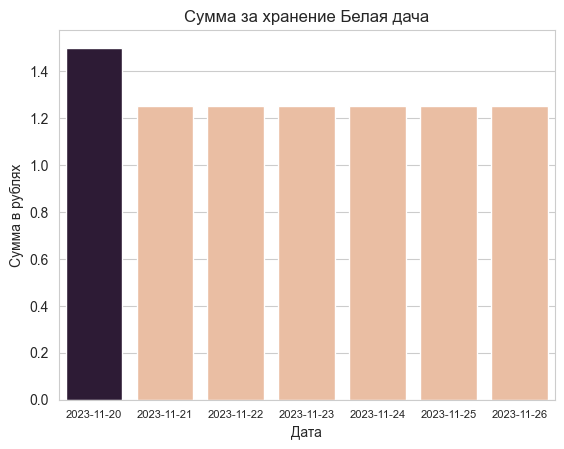

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2728\3077699709.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


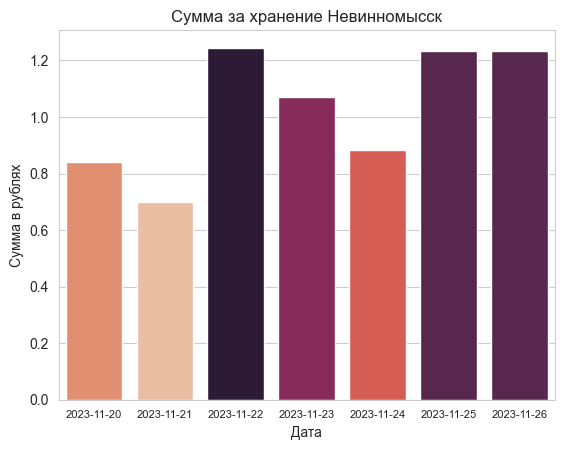

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2728\3077699709.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_table, x=sum_table.index, y=city, ax=ax, palette=colors_mapped)


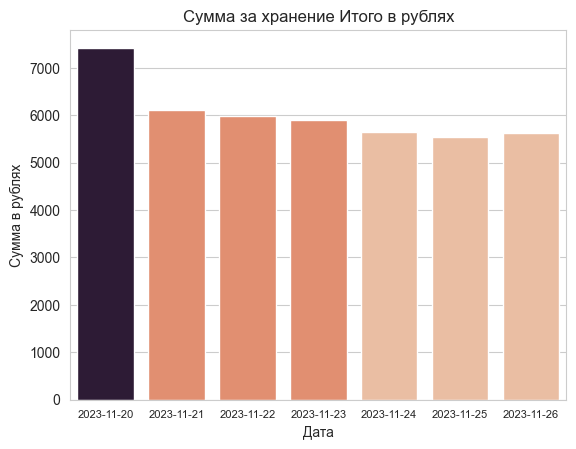

In [16]:
excpt_cities = ['Чехов 2', 'Екатеринбург - Испытателей 14г', 'Санкт-Петербург Шушары', 'Санкт-Петербург Уткина Заводь', 'Радумля СГТ', 'Белые Столбы', 'Белая дача']
create_remains_on_tariff(excpt_city_names=excpt_cities)